In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV


In [ ]:

# Load the data into a pandas DataFrame
df = pd.read_csv('data.csv')
#print(df.head())
# Fill missing values with 0
df = df.fillna(0)

In [ ]:
# Define a function that calculates daily counts for a single country
def calculate_daily_counts(df_country):
    df_country['Cases'] = df_country['Cases'].diff()
    df_country.at[df_country.index[0], 'Cases'] = df_country.at[df_country.index[1], 'Cases']

    df_country['Deaths'] = df_country['Deaths'].diff()
    df_country.at[df_country.index[0], 'Deaths'] = df_country.at[df_country.index[1], 'Deaths']

    return df_country

# Split the DataFrame by 'Entity', apply the function to each group, and combine the groups back together
df = df.groupby('Entity', group_keys=False).apply(calculate_daily_counts)
#Preproccess the data to exclude negative deaths and cases
df.loc[df['Deaths'] < 0, 'Deaths'] = 0
df.loc[df['Cases'] < 0, 'Cases'] = 0


In [ ]:
df_greece = df[df['Entity'] == 'Greece']
# Replace NaNs with 0
df_greece['Daily tests'].fillna(0, inplace=True)

# Find the first non-zero 'Daily tests' value
first_nonzero_tests = df_greece['Daily tests'].ne(0).idxmax()

# Discard all rows before the first non-zero 'Daily tests' value
df_greece = df_greece.loc[first_nonzero_tests:]
# Calculate the positivity rate
df_greece['Positivity Rate'] = df_greece['Cases'] / df_greece['Daily tests']

# Fill any missing or infinite values resulting from division by zero with 0
df_greece['Positivity Rate'] = df_greece['Positivity Rate'].replace([np.inf, -np.inf], np.nan)
df_greece['Positivity Rate'].fillna(0, inplace=True)
# Compute the rolling mean with a window size of 4
df_greece['Positivity Rate 4-Day MA'] = df_greece['Positivity Rate'].rolling(window=3).mean()
#Identify where the 0 values in the positivity rate are
zero_pos_rate_indices = df_greece[df_greece['Positivity Rate'] == 0].index
# Replace these 0 values with the 4-day moving average

df_greece.loc[zero_pos_rate_indices, 'Positivity Rate'] = df_greece.loc[zero_pos_rate_indices, 'Positivity Rate 4-Day MA']
df_greece.head

<ipython-input-73-226203d03f11>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_greece['Daily tests'].fillna(0, inplace=True)


<bound method NDFrame.head of        Entity Continent  Latitude  Longitude  Average temperature per year  \
11818  Greece    Europe     39.07      21.82                            17   
11819  Greece    Europe     39.07      21.82                            17   
11820  Greece    Europe     39.07      21.82                            17   
11821  Greece    Europe     39.07      21.82                            17   
11822  Greece    Europe     39.07      21.82                            17   
...       ...       ...       ...        ...                           ...   
12166  Greece    Europe     39.07      21.82                            17   
12167  Greece    Europe     39.07      21.82                            17   
12168  Greece    Europe     39.07      21.82                            17   
12169  Greece    Europe     39.07      21.82                            17   
12170  Greece    Europe     39.07      21.82                            17   

       Hospital beds per 1000 peo

In [ ]:
window = 5
window_for_loops = window+1
df_greece['Positivity Rate Future'] = df_greece['Positivity Rate'].shift(-3)

# 2. Feature engineering
for i in range(1, window_for_loops):
  df_greece.loc[:, f'Positivity Rate Lag {i}'] = df_greece['Positivity Rate'].shift(i)
df_greece = df_greece.dropna()

corr_coef = df_greece['Deaths'].corr(df_greece['Positivity Rate'])

# Create new feature
df_greece['Deaths Weighted'] = df_greece['Deaths'] * corr_coef

# 3. Splitting the data
train = df_greece[df_greece['Date'] < '2021-01-01']
test = df_greece[df_greece['Date'] >= '2021-01-01']
# Compute correlation coefficient between 'Deaths' and 'Positivity Rate'


<ipython-input-74-08aa8f2946ad>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_greece['Deaths Weighted'] = df_greece['Deaths'] * corr_coef


In [ ]:

# Add new feature to your feature matrices
#X_train = train[[f'Positivity Rate Lag {i}' for i in range(1, window_for_loops)] + ['Deaths Weighted']]
X_train = train[[f'Positivity Rate Lag {i}' for i in range(1, window_for_loops)]]
y_train = train['Positivity Rate Future']

X_test = test[[f'Positivity Rate Lag {i}' for i in range(1, window_for_loops)]]
#X_test = test[[f'Positivity Rate Lag {i}' for i in range(1, window_for_loops)] + ['Deaths Weighted']]
y_test = test['Positivity Rate Future']



In [ ]:


# Scale the features
scaler = StandardScaler()
#X_train_scaled = scaler.fit_transform(X_train)
#X_test_scaled = scaler.transform(X_test)
X_train_scaled = X_train
X_test_scaled = X_test

parameters = {'kernel': ['rbf','poly','linear'],
              'C': [0.1, 1,10,100],
              'gamma': [0.1, 1, 10, 100],
              'epsilon': [0.1, 0.2, 0.3, 0.4, 0.5]}
svm = SVR()
grid_search = GridSearchCV(svm, parameters)
grid_search.fit(X_train_scaled, y_train)

best_parameters = grid_search.best_params_
print("Best parameters: ", best_parameters)

svm = SVR(kernel=best_parameters['kernel'], C=best_parameters['C'], gamma=best_parameters['gamma'], epsilon=best_parameters['epsilon'])
svm.fit(X_train_scaled, y_train)

# Make predictions
y_train_pred = svm.predict(X_train_scaled)
y_test_pred = svm.predict(X_test_scaled)

# Compute MAE
mse_train = mean_squared_error(y_train, y_train_pred)
mse_test = mean_squared_error(y_test, y_test_pred)

print('Train MSE: ', mse_train)
print('Test MSE: ', mse_test)


Best parameters:  {'C': 100, 'epsilon': 0.2, 'gamma': 1, 'kernel': 'rbf'}
Train MSE:  0.0029062381038616396
Test MSE:  0.004997135542045255


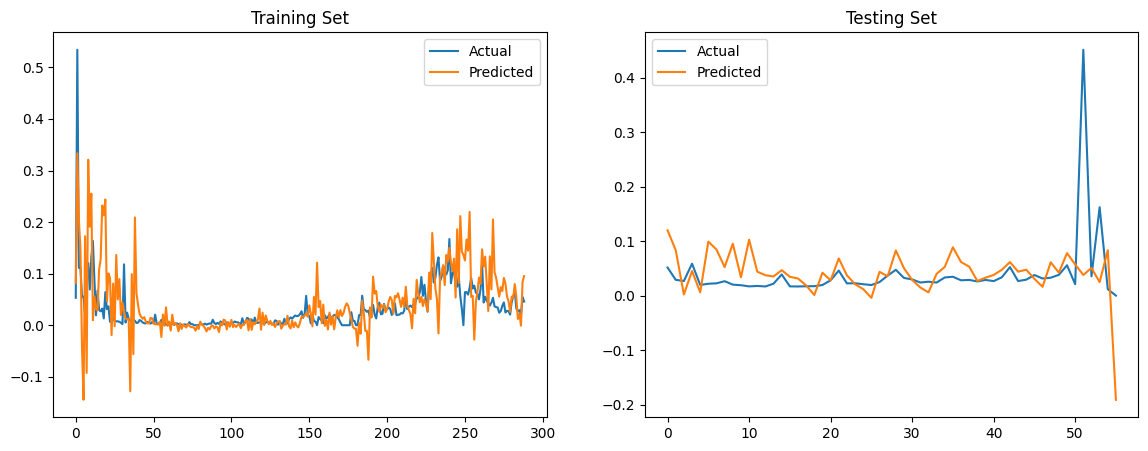

In [ ]:
import matplotlib.pyplot as plt

# Predictions
y_train_pred = svm.predict(X_train_scaled)
y_test_pred = svm.predict(X_test_scaled)

plt.figure(figsize=(14, 5))

# Plot actual and predicted values of the training set
plt.subplot(1, 2, 1)
plt.plot(y_train.values, label='Actual')
plt.plot(y_train_pred, label='Predicted')
plt.title('Training Set')
plt.legend()

# Plot actual and predicted values of the testing set
plt.subplot(1, 2, 2)
plt.plot(y_test.values, label='Actual')
plt.plot(y_test_pred, label='Predicted')
plt.title('Testing Set')
plt.legend()

plt.show()
